# Numerical Exercises 2

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

csv_path = "./CSV/"

In this exercises I am going, in a first moment, to add a new technique for the evaluation of integrals, known as importance sampling. This technique should, in theory, allow us to obtain a lower uncertainty on the final integral evaluation by sampling the integration interval more wisely. 

In the second part of this exercises, I will focus on random walks (both discrete and continuous). In particular I am going to check whether the simulated random walks manifest a diffusive behavior, as theoretically stated.

## Exercise 2.1

The goal of this exercise is to compute numerically the value of the integral $I$, defined as follows: $$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$ To do this I will firstly sample $x$ according to a uniform distribution, and then use importance sampling, where the integration variable is sampled along a distribution "more similar" to the integrand (considering only the integration region). I will then compare the two results to see whether the importance sampling technique gave better results (as theoretically expected). In both cases data-blocking has been utilized, with $10^5$ throws grouped in $100$ blocks.

In [13]:
def quad_func(x, a, c):
    return a*x**2 + c

The distribution chosen for the importance sampling can, in principle, be any finite, positive and normalized distribution that vaguely resembles the integrand (in particular it may have the same zeros, at least in the integration region). I then chose to use the distribution $p(x)=\frac{3}{2}(1-x^2)$. This distribution approximates very well the integrand, but its cumulative distribution cannot be easily inverted and thus $p(x)$ cannot be directly sampled. To solve this problem I sampled the distribution using the accept-reject technique. To verify if the sampling procedure was working I dumped some sampled points, constructed an histogram and fitted a quadratic distribution on it, as shown in the following graph.

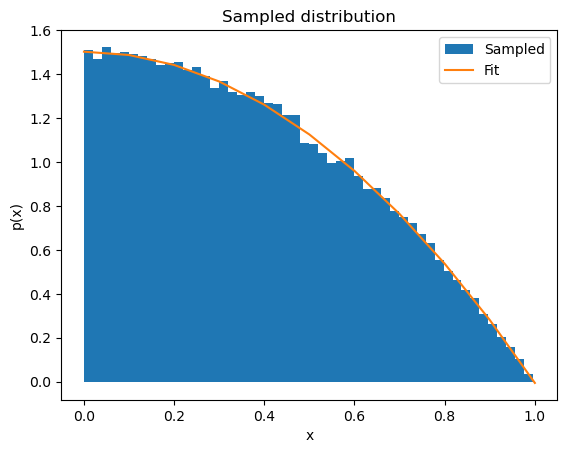

a: -1.5083389356166048	c: 1.5027345996347505


In [27]:
quad_distrib_data = np.loadtxt(csv_path + "Ex2_1_quadratic_distr.csv", delimiter=",")

counts, bins = np.histogram(quad_distrib_data, 50, density = True)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, pcov = curve_fit(quad_func, binscenters, counts)
x_fit = np.arange(0, 1.1, 0.1)

plt.hist(bins[:-1], bins, weights=counts, label = "Sampled")
plt.plot(x_fit, quad_func(x_fit, *popt), label = "Fit")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.title("Sampled distribution")
plt.legend()
plt.show()

print("a: {}\tc: {}".format(popt[0], popt[1]))

Both the fitted parameter $a$ and $c$ are really close to their theoretical value ($-\frac{3}{2}, \frac{3}{2}$) thus suggesting a correct sample procedure. It is then possible to compute the integral using the two methods.

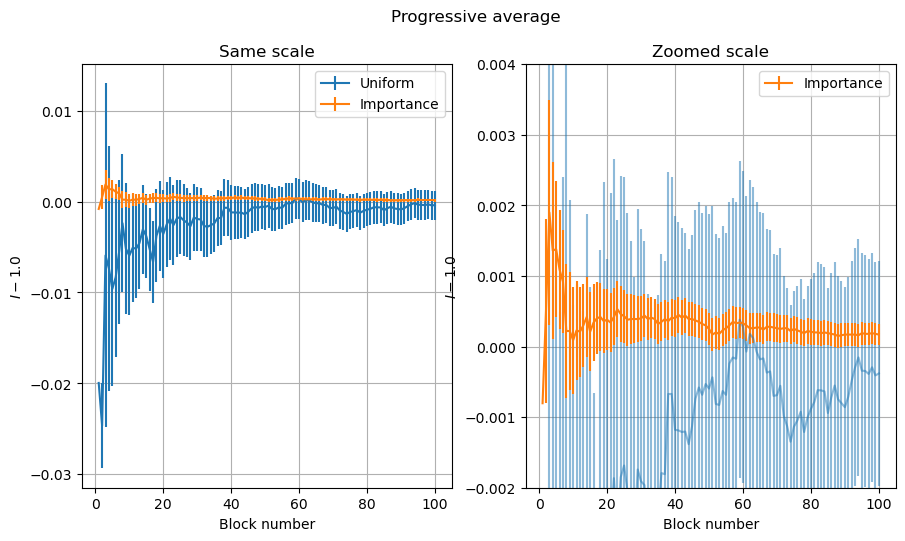

Uniform samling:
Final value: 0.999619	Error: 0.00158973
---------------------------------------------------------------
Importance samling:
Final value: 1.00017	Error: 0.000154403


In [55]:
uniform_data = np.loadtxt(csv_path + "Ex2_1_uniform.csv", delimiter=",")
quad_data = np.loadtxt(csv_path + "Ex2_1_quad.csv", delimiter=",")

plt.subplot(1, 2, 1)
plt.errorbar(np.arange(1, 101, 1), uniform_data[:,0] - 1, yerr=uniform_data[:,1], label = "Uniform")
plt.errorbar(np.arange(1, 101, 1), quad_data[:,0] - 1, yerr=quad_data[:,1], label = "Importance")
plt.grid(True)
plt.xlabel("Block number")
plt.ylabel(r"$I - 1.0$")
plt.title("Same scale")
plt.legend()
plt.subplot(1, 2, 2)
plt.errorbar(np.arange(1, 101, 1), uniform_data[:,0] - 1, yerr=uniform_data[:,1], alpha = 0.5)
plt.errorbar(np.arange(1, 101, 1), quad_data[:,0] - 1, yerr=quad_data[:,1], label = "Importance")
plt.ylim(-0.002,0.004)
plt.xlabel("Block number")
plt.ylabel(r"$I - 1.0$")
plt.title("Zoomed scale")
plt.grid(True)
plt.legend()
plt.gcf().set_size_inches(10.5,5.5)
plt.gcf().suptitle("Progressive average")
plt.show()

print("Uniform samling:\nFinal value: {}\tError: {}".format(uniform_data[-1,0], uniform_data[-1,1]))
print("---------------------------------------------------------------")
print("Importance samling:\nFinal value: {}\tError: {}".format(quad_data[-1,0], quad_data[-1,1]))

It is clear that with both methods the computed integral is compatible (within ore or slightly more than one standard deviation) with the expected results. Using importance sampling, anyway, the final error is around $\frac{1}{10}$ of the error obtained using uniform sampling. Furthermore, the result obtained via importance sampling converges faster and tends to remain more stable. As a final note I might say that besides all these good features, importance sampling in this exercise relies on an accept-reject technique, which is computationally inefficient; a better approach could be using an easy-to-invert approximating distribution, even if less similar to the integrand (in this case, however, the final error may be larger than what I have obtained).

## Exercise 2.2

In this exercise I will simulate a Random Walk (RW) in space, at first using discrete steps in an Euclidean lattice and then using continuous steps. The final goal is to verify whether the square root of the average squared radius for these two RWs has a diffusive behavior, i.e. grows as $k\sqrt{N}$ (with $N$ number of steps). To do this I simultaneously started $M = 10^4$ identical random walkers, and I let them complete $N=100$ steps; these walkers are then grouped in $B = 100$ blocks, and for each block the average squared-radius is computed. I can then extract the global average at the $i-th$ step as the average of block-averages, and its error as the standard deviation from the global average. I then try to fit the result with a typical diffusive curve ($k\sqrt{N}$) and see if the fitted curve is compatible with the simulation data.

### 2.2.1

In [17]:
def sqrt_func(x, k):
    return k * np.sqrt(x)

As said, in this part I am going to simulate a random walk on a cubic lattice with step $a=1.0$: at each step the walker can move along one of the three axis in the positive or negative direction, all at random. At the end of each step the global average squared-radius is computed as previously described.

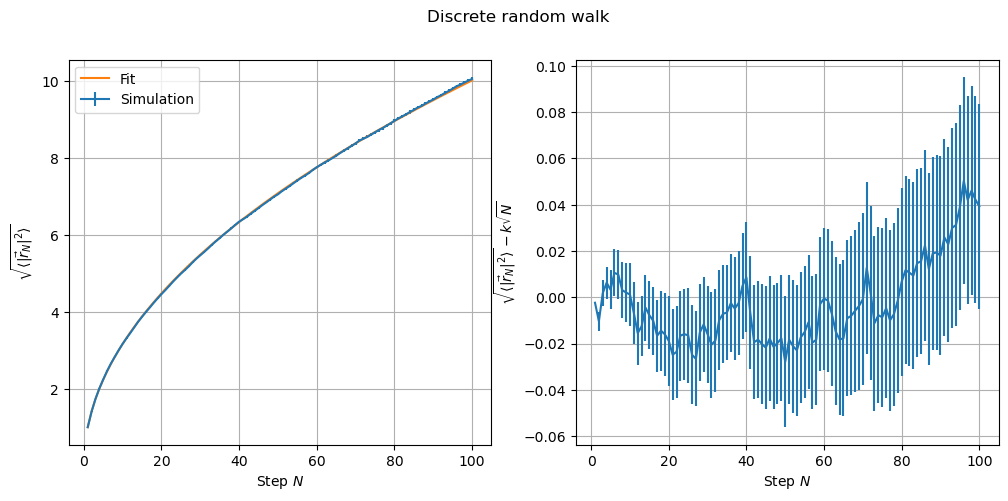

Diffusive parameter k: 1.0023427421981987


In [86]:
discrete_data = np.loadtxt(csv_path + "Ex2_2_discrete.csv", delimiter=",")

popt, pcov = curve_fit(sqrt_func, np.arange(1, 101, 1), discrete_data[:,0])

x = np.arange(1, 101, 1)

plt.subplot(1,2,1)
plt.errorbar(x, discrete_data[:,0], yerr=discrete_data[:,1], label = "Simulation")
plt.plot(x, sqrt_func(x, *popt), label = "Fit")
plt.xlabel(r"Step $N$")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle}$")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.errorbar(x, discrete_data[:,0] - sqrt_func(x, *popt), yerr=discrete_data[:,1])
plt.xlabel(r"Step $N$")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle} - k \sqrt{N}$")
plt.grid(True)

plt.gcf().set_size_inches(12, 5)
plt.gcf().suptitle("Discrete random walk")
plt.show()

print("Diffusive parameter k: {}".format(popt[0]))

From the first graph is clear that the fitted curve matches quite well the simulation data, thus confirming the diffusive behavior. This fact is indeed enforced by the second graph, where the difference between the fit curve and the experimental data is shown: here we can see that this difference is (especially for large enough $N$) within one or two standard deviation, thus confirming our hypothesis.

### 2.2.2

Now I will repeat the same process described in Exercise 2.2.1 but with a continuous random walk. In such a RW at each step the walker can move in any direction with radius $a = 1$, i.e. the allowed positions at each steps are identified by the points of a unitary sphere centered around the previous position. So as to simulate this RW we then need to uniformly sample points in a sphere (I will add a couple of comments on this procedure at the end of this notebook). Apart from that everything is unchanged from the previous exercise.

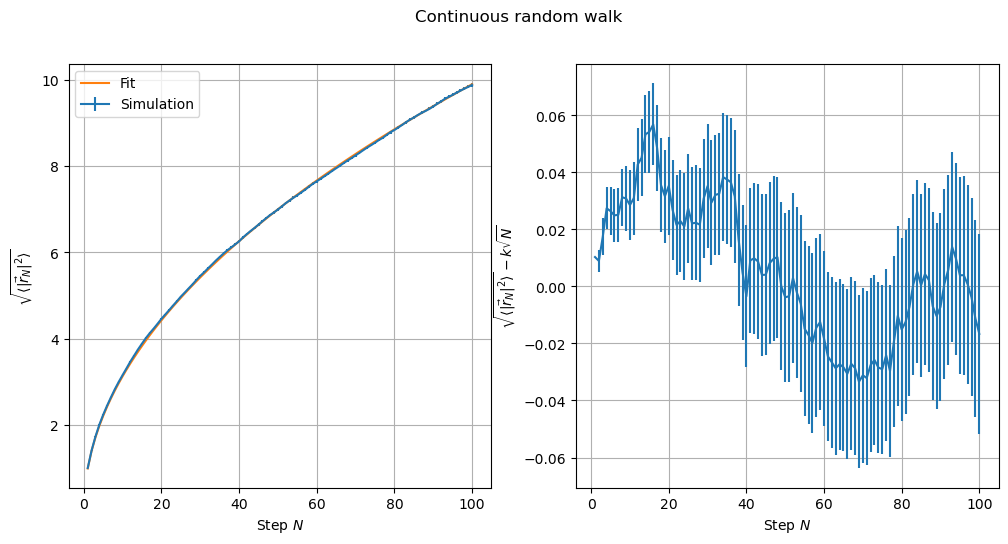

Diffusive parameter k: 0.989686353562888


In [87]:
continue_data = np.loadtxt(csv_path + "Ex2_2_continue.csv", delimiter=",")

popt, pcov = curve_fit(sqrt_func, np.arange(1, 101, 1), continue_data[:,0])

plt.subplot(1,2,1)
plt.errorbar(x, continue_data[:,0], yerr=continue_data[:,1], label = "Simulation")
plt.plot(x, sqrt_func(x, *popt), label = "Fit")
plt.xlabel(r"Step $N$")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle}$")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.errorbar(x, continue_data[:,0] - sqrt_func(x, *popt), yerr=continue_data[:,1])
plt.xlabel(r"Step $N$")
plt.ylabel(r"$\sqrt{\langle |\vec{r}_N|^2 \rangle} - k \sqrt{N}$")
plt.grid(True)

plt.gcf().set_size_inches(12, 5.5)
plt.gcf().suptitle("Continuous random walk")
plt.show()

print("Diffusive parameter k: {}".format(popt[0]))

Again we can see that the simulated RW has a diffusive behavior, as confirmed by a good superposition between:
1. The fitted curve and the experimental data 
2. The difference between said variables, compatible with zero within a couple of standard deviations at high $N$.

#### Sampling points on a sphere

To uniformly sample points on a unitary (or equivalently any) sphere, it's not enough to uniformly sample two angles, $\theta\in[0,\pi)$ and $\varphi\in[0,2\pi)$, since this would lead to a non-uniformly sampling (poles would be oversampled). A different procedure (better described in Ex2_2.cpp) has then be used. To evaluate this procedure some sampled points have been graphed below.

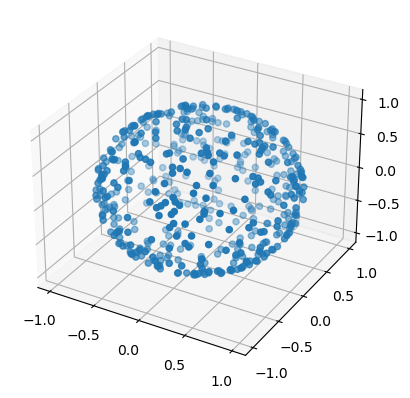

In [ ]:
polar_pos_data = np.loadtxt(csv_path + "Ex2_2_continue_polar.csv", delimiter=",")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Display only last 500 point not to overcrowd scatter

x = np.sin(polar_pos_data[-500:,0]) * np.cos(polar_pos_data[-500:,1])
y = np.sin(polar_pos_data[-500:,0]) * np.sin(polar_pos_data[-500:,1])
z = np.cos(polar_pos_data[-500:,0])

ax.scatter(x, y, z)


As we can see, the sampled points uniformly cover the sphere surface, thus indicating a correct sampling procedure.